# 推定

## サイコロ問題

多面体のサイコロを投げる例で、事後確率が変わる様子を観察する

いつものライブラリをインポート

In [313]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

事前確率から事後確率を計算するクラス（共通）

以下のコードを参考にしているが、元のコードが複雑だったので必要な処理だけ雰囲気で書いている。  
GitHub: [AllenDowney/ThinkBayes](https://github.com/AllenDowney/ThinkBayes)

In [318]:
class Pmf():
    
    """Probability Mass Function（確率質量関数）"""
    
    def __init__(self):
        self.hypos = []
        self.priors = {}
        self.priors_given_likelihoods = {}
        self.posteriors = {}
    
    def Set(self, x, prob):
        self.hypos.append(x)
        self.priors[x] = prob
    
    def Values(self):
        return self.hypos

    def Incr(self, x, i):
        self.priors[x] = self.priors[x] + 1
        
    def Mult(self, x, likelihood):
        self.priors_given_likelihoods[x] = self.priors[x] * likelihood
        
    def Normalize(self):
        for x in self.priors_given_likelihoods.keys():
            self.posteriors[x] = self.priors_given_likelihoods[x] / (sum(self.priors_given_likelihoods.values()))
            self.priors[x] = self.posteriors[x] # TODO 正規化後は、事後分布が次の事前分布になる

    def Items(self):
        return self.posteriors.items()
    
    def Posts(self):
        return self.posteriors
            
    def Prob(self, x):
        return self.posteriors[x]
    
class Suite(Pmf):
    
    def __init__(self, hypos):
        Pmf.__init__(self) # TODO ここの書き方がよくわからない。Mix-inみたいなの？
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
        
    def Likelihood(self, data, hypo):
        raise UnimplementedMethodException()
        
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
        
    def Print(self):
        """Prints the hypotheses and their probabilities."""
        for hypo, prob in sorted(self.Items()):
             print("{}: {}".format(hypo, prob))

サイコロの場合の尤度を設定

* 多面体のサイコロを使用する
    * 4面体のサイコロで出る目   => [1, 2, 3, 4]
    * 6面体のサイコロで出る目   => [1, 2, 3, 4, 5, 6]
    * 8面体のサイコロで出る目   => [1, 2, 3, 4, 5, 6, 7, 8]
    * 12面体のサイコロで出る目  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
    * 20面体のサイコロで出る目 =>  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [320]:
class Dice(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data: # 例） 4面体のサイコロで6が出る確率は0
            return 0
        else:
            return 1.0 / hypo # 例） 4面体のサイコロで4が出る確率は1/4、6面体のサイコロで4が出る確率は1/6

# サイコロをたくさん投げる

確率分布をプロットする関数

In [316]:
def plot_probability(d, title):
    df = pd.DataFrame()
    df['dice'] = d.keys()
    df['probability'] = d.values()
    
    sns.set_color_codes("muted")
    ax = sns.barplot(x="dice", y="probability", data=df, label="Total", color="b")
    ax.set(ylim=(0, 1))
    ax.set_title(title)
    plt.show()

サイコロを複数回投げて、どのサイコロを投げているかを推定する

* 投げた結果: [6, 8, 7, 7, 5, 4]
* サイコロを投げる度に、8面体である確率が高くなることが見て取れる。

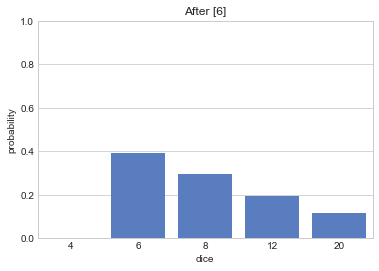

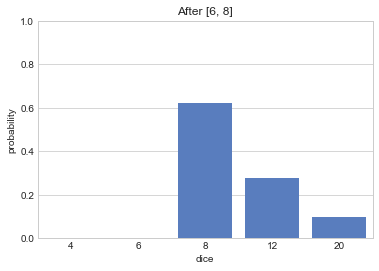

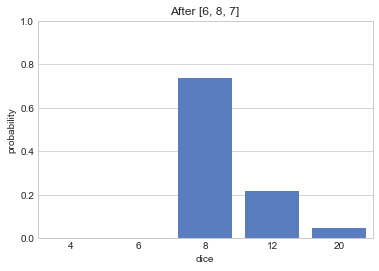

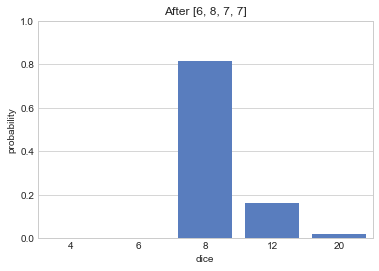

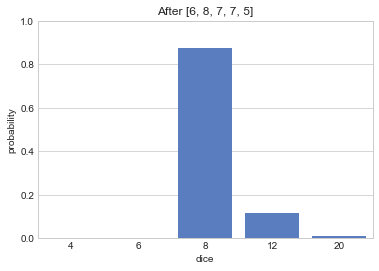

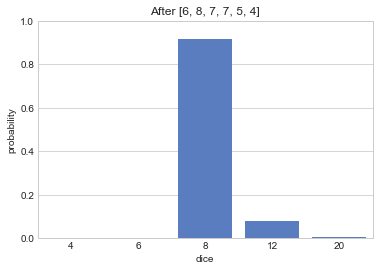

In [325]:
suite = Dice([4, 6, 8, 12, 20])

result = []

rolls = [6, 8, 7, 7, 5, 4]
for i, roll in enumerate(rolls):
    suite.Update(roll)
    posts = suite.Posts().copy()
    result.append(posts)
    plot_probability(posts, 'After {}'.format(rolls[:i+1]))

サイコロを投げる回数の推移によって確率が変わる様子をプロット

* 一投目（一番左）のときには、それぞれ6〜20面体のどのサイコロを投げたかの確率は大体低い（一投目が**6**だったので4面体である確率は0）
* 二投目（左から二番目）が**8**だったので、6面体である確率は0になった。残りは8〜20面体だが、8面体である確率が最も高い
* 三投目以降に出目が [7, 7, 5, 4] となっており、もし12〜20面体であれば出るはずの**9以降の出目が存在しない**ため一定して8面体である確率が最も高い
* もちろん12〜20面体のサイコロで、**偶然8以下の出目が出続けた**可能性は存在するが、確率は極めて低い（当たり前！）

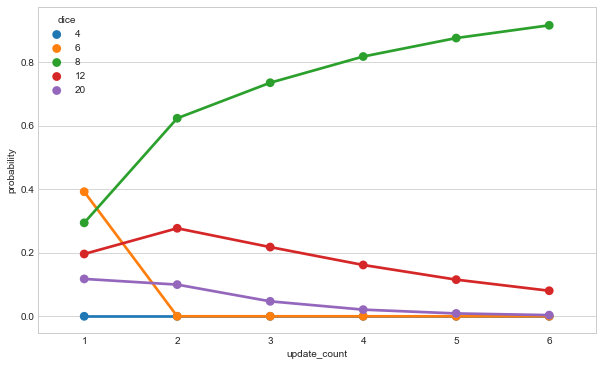

In [329]:
df = pd.DataFrame()
for i, d in enumerate(result):
    rows = pd.DataFrame()
    rows['dice'] = d.keys()
    rows['probability'] = d.values()
    rows.insert(0, 'update_count', i+1)
    df = pd.concat([df, rows])
df = df.reset_index(drop=True)
df["update_count"] = df["update_count"].astype('category')
df["dice"] = df["dice"].astype('category')

plt.figure(figsize=(10, 6))
ax = sns.pointplot(x="update_count", y="probability", hue="dice", data=df)